<div style="color: #00FF00;">
    <h3>
        UNIVERSIDADE FEDERAL DO MARANHÃO<br>
        CENTRO DE CIÊNCIAS EXATAS E TECNOLOGIA - CCET<br>
        COORDENAÇÃO DO CURSO DE ENGENHARIA DA COMPUTAÇÃO - CCEC<br>
        APRENDIZADO DE MÁQUINA – Prof. Alex Oliveira Barradas Filho
    </h3>
</div>
<br>
<br>
<div style="color: #00FF00;">
    <h5>
        Francisco Elias da Silva Fernandes<br>
        Rosivânia da Silva Viana<br>
        Caio Reis Batista<br>
        Daniel Aires<br>
        Katarina Ires
    </h5>
</div>

# Análise e Previsão de Arritmias Cardíacas (CRISP-DM)

Este notebook implementa uma solução para a classificação de arritmias cardíacas, seguindo a metodologia CRISP-DM (Cross-Industry Standard Process for Data Mining). O foco principal é o tratamento de dados desbalanceados e a criação de pipelines robustos para processamento e treinamento de modelos de Machine Learning.

## 1. Entendimento do Negócio (Business Understanding)

**Objetivo:** Desenvolver um modelo de Machine Learning capaz de classificar diferentes tipos de arritmias cardíacas a partir de dados de eletrocardiograma (ECG). O desafio principal é lidar com o desbalanceamento inerente aos dados médicos, onde a maioria dos pacientes não apresenta arritmia ou apresenta tipos raros.

**Métricas de Sucesso:** Devido ao desbalanceamento de classes, métricas como F1-score (macro ou ponderado), Recall e Precision serão prioritárias em detrimento da acurácia simples.

## 2. Entendimento dos Dados (Data Understanding)

Nesta fase, exploramos o dataset para entender sua estrutura, identificar a qualidade dos dados e descobrir insights iniciais.

### 2.1 Carregamento e Visão Geral Inicial

O dataset `arrhythmia.data` contém 279 atributos e uma classe alvo (coluna 280). Os atributos incluem informações demográficas, resultados de exames de ECG e a classificação da arritmia.

## 1. Carregamento e Visão Geral Inicial dos Dados

Esta célula carrega o dataset, define os nomes das colunas e exibe as primeiras linhas e informações básicas.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo os nomes das colunas conforme a documentação
column_names_full = [
    'age', 'sex', 'height', 'weight', 'QRS_duration', 'PR_interval', 'QT_interval',
    'T_interval', 'P_interval', 'QRS_vector', 'T_vector', 'P_vector', 'QRST_vector', 'J_vector',
    'heart_rate', # Atributo 15
]

width_measures = ['Q_width', 'R_width', 'S_width', 'R_prime_width', 'S_prime_width',
                  'Num_Intrinsic_Deflections', 'Irregular_R_Wave', 'Diphasic_R_Derivation',
                  'Irregular_P_Wave', 'Diphasic_P_Derivation', 'Irregular_T_Wave', 'Diphasic_T_Derivation']
leads = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

for lead in leads:
    for measure in width_measures:
        column_names_full.append(f'{lead}_{measure}')

amplitude_measures = ['JJ_amp', 'Q_amp', 'R_amp', 'S_amp', 'R_prime_amp', 'S_prime_amp',
                      'P_amp', 'T_amp', 'QRSA', 'QRSTA']

for lead in leads:
    for measure in amplitude_measures:
        column_names_full.append(f'{lead}_{measure}')

column_names_full.append('class_label')

# Carrega o dataset
df = pd.read_csv('data/arrhythmia.data', header=None, na_values='?', names=column_names_full)

print('Primeiras 5 linhas do DataFrame:')
display(df.head())

print('\nInformações gerais do DataFrame:')
df.info()

print('\nEstatísticas descritivas:')
display(df.describe())

Primeiras 5 linhas do DataFrame:


,age,sex,height,weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_vector,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,class_label
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7



Informações gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to class_label
dtypes: float64(125), int64(155)
memory usage: 988.9 KB

Estatísticas descritivas:


,age,sex,height,weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_vector,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,class_label
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


## 2. Análise de Valores Ausentes

É crucial entender a quantidade e a distribuição dos valores ausentes para decidir a melhor estratégia de tratamento.

Valores Ausentes por Coluna (apenas colunas com missing):


,Missing Count,Missing Percentage
J_vector,376,83.185841
P_vector,22,4.867257
T_vector,8,1.769912
QRST_vector,1,0.221239
heart_rate,1,0.221239


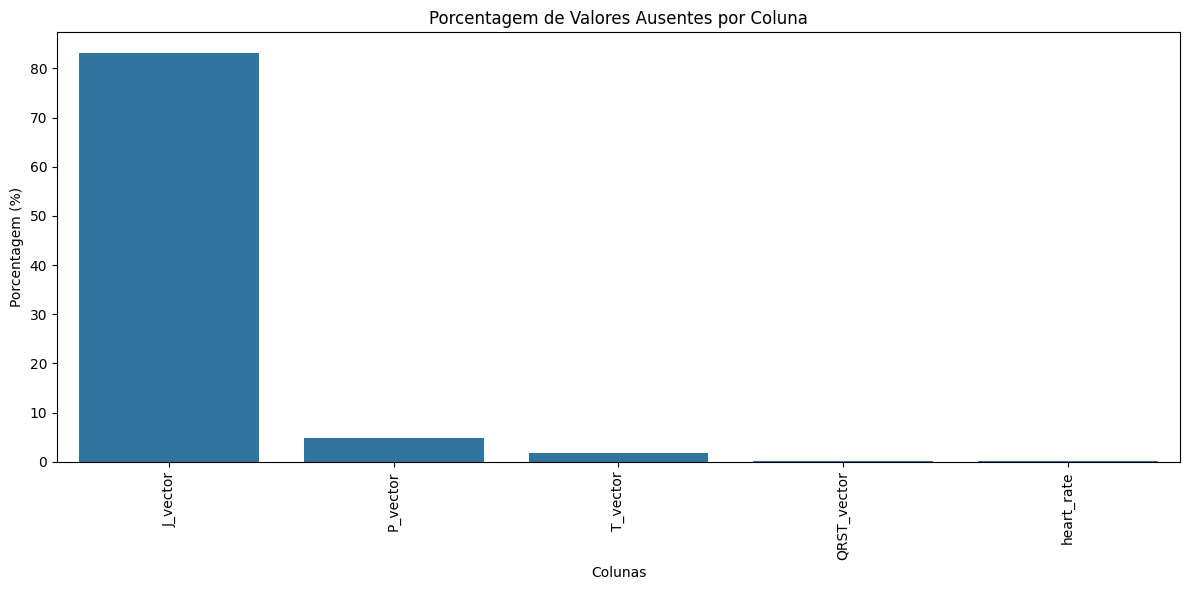

In [2]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

print('Valores Ausentes por Coluna (apenas colunas com missing):')
display(missing_df)

# Visualização da distribuição de valores ausentes
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_df.index, y=missing_df['Missing Percentage'])
plt.xticks(rotation=90)
plt.title('Porcentagem de Valores Ausentes por Coluna')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Colunas')
plt.tight_layout()
plt.show()

### 2.1 Análise da Distribuição da Classe Alvo

A distribuição da classe alvo é fundamental para identificar o problema de desbalanceamento.

Distribuição da Classe Alvo:


,Count,Percentage
class_label,,
1,245,54.203540
2,44,9.734513
3,15,3.318584
4,15,3.318584
5,13,2.876106
6,25,5.530973
7,3,0.663717
8,2,0.442478
9,9,1.991150


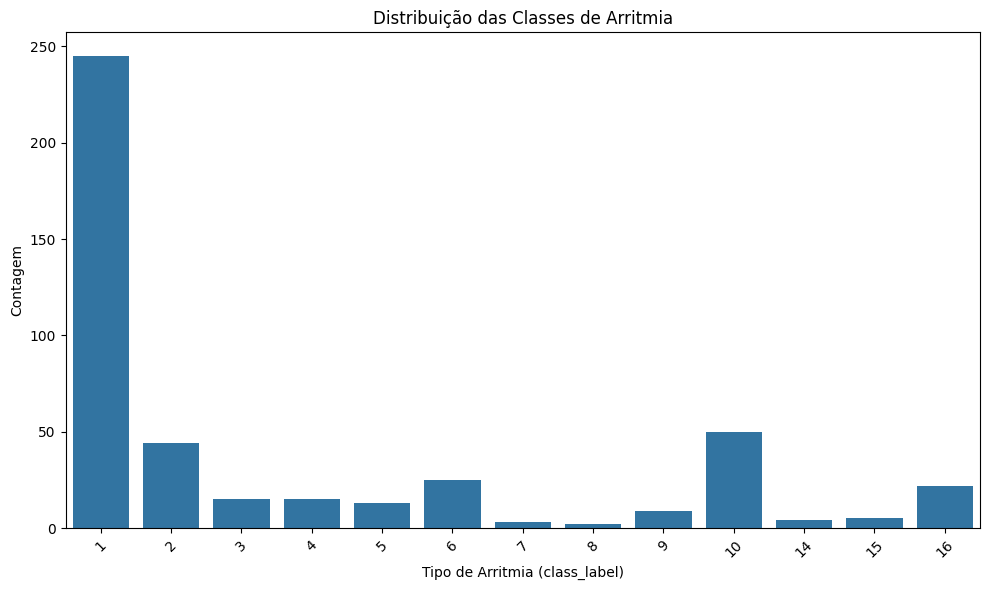

In [3]:
class_distribution = df['class_label'].value_counts().sort_index()
class_percentage = (df['class_label'].value_counts(normalize=True) * 100).sort_index()

class_df = pd.DataFrame({'Count': class_distribution, 'Percentage': class_percentage})
print('Distribuição da Classe Alvo:')
display(class_df)

# Visualização da distribuição da classe alvo
plt.figure(figsize=(10, 6))
sns.barplot(x=class_df.index, y=class_df['Count'])
plt.title('Distribuição das Classes de Arritmia')
plt.xlabel('Tipo de Arritmia (class_label)')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Preparação dos Dados (Data Preparation)

Nesta fase, realizamos as transformações necessárias nos dados para prepará-los para a modelagem. Isso inclui o tratamento de valores ausentes, a remoção de colunas problemáticas, a engenharia de features (se aplicável) e o balanceamento das classes.

### 3.1 Tratamento de Valores Ausentes e Remoção de Colunas

Com base na análise da fase anterior, decidimos remover colunas com uma alta porcentagem de valores ausentes e imputar os valores restantes com a mediana, que é uma medida eficaz para dados com outliers.

In [4]:
# Remover colunas com mais de 40% de valores ausentes (ex: 'J_vector')
columns_to_drop = missing_percentage[missing_percentage > 40].index.tolist()
df_cleaned = df.drop(columns=columns_to_drop)
print(f'Colunas removidas devido a muitos valores ausentes: {columns_to_drop}')
print(f'Shape do DataFrame após remoção de colunas: {df_cleaned.shape}')

# Imputar valores ausentes restantes com a mediana
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64'] and df_cleaned[col].isnull().sum() > 0:
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

print(f'Total de valores ausentes após tratamento: {df_cleaned.isnull().sum().sum()}')

# Separar features (X) e target (y)
X = df_cleaned.drop(columns=['class_label'])
y = df_cleaned['class_label']

# --- Estratégia: Remapeamento de Classes Raras ---
# Identificar classes com poucos exemplos (e.g., menos de 5 ou 10, dependendo do n_splits do StratifiedKFold)
# e agrupá-las em uma única classe 'Outras Arritmias Raras' (por exemplo, classe 0 ou uma nova classe alta).
# Para este dataset, as classes 7, 8, 11, 14, 15, 16 têm 1, 2, 1, 4, 5, 22 exemplos respectivamente no dataset original.
# Vamos definir um limiar de 10 exemplos para classes raras.
class_counts = y.value_counts()
rare_classes = class_counts[class_counts < 10].index.tolist()

# Definir um novo rótulo para as classes raras. Usaremos 99 (temporário) para 'Outras Arritmias Raras'
# e remapearemos as outras classes sequencialmente.
# É importante que a classe majoritária (1) não seja remapeada para 0 se 0 for a nova classe 'outras'.
# Uma abordagem é remapear as classes raras para um novo rótulo que não colida com as classes existentes e depois remapear tudo para 0 a N-1.
new_rare_class_label = 99 # Um rótulo temporário alto para classes raras
y_remapped_temp = y.copy()
for cls in rare_classes:
    y_remapped_temp[y_remapped_temp == cls] = new_rare_class_label

# Agora, remapear todas as classes para um intervalo de 0 a N-1
unique_classes_final = sorted(y_remapped_temp.unique())
class_mapping_final = {cls: i for i, cls in enumerate(unique_classes_final)}
y_mapped = y_remapped_temp.map(class_mapping_final)

print(f'Classes raras agrupadas: {rare_classes}')
print(f'Mapeamento de classes final: {class_mapping_final}')
print(f'Distribuição da classe alvo mapeada após remapeamento: {Counter(y_mapped)}')

Colunas removidas devido a muitos valores ausentes: ['J_vector']
Shape do DataFrame após remoção de colunas: (452, 279)
Total de valores ausentes após tratamento: 0
Classes raras agrupadas: [9, 15, 14, 7, 8]
Mapeamento de classes final: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(10): 6, np.int64(16): 7, np.int64(99): 8}
Distribuição da classe alvo mapeada após remapeamento: Counter({0: 245, 6: 50, 1: 44, 5: 25, 8: 23, 7: 22, 2: 15, 3: 15, 4: 13})


### 3.2 Divisão dos Dados e Balanceamento de Classes (SMOTE)

A divisão dos dados em conjuntos de treino e teste deve ser feita antes do balanceamento para evitar *data leakage*. O SMOTE será aplicado apenas no conjunto de treino.

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped
)

print(f'Shape de X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape de X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'Distribuição de classes em y_train antes do SMOTE: {Counter(y_train)}')

# SMOTE será aplicado dentro do pipeline para evitar data leakage

Shape de X_train: (361, 278), y_train: (361,)
Shape de X_test: (91, 278), y_test: (91,)
Distribuição de classes em y_train antes do SMOTE: Counter({0: 196, 6: 40, 1: 35, 5: 20, 7: 18, 8: 18, 2: 12, 3: 12, 4: 10})


## 4. Modelagem (Modeling)

Nesta fase, construímos e treinamos os modelos de Machine Learning. Utilizaremos pipelines para encapsular as etapas de pré-processamento, seleção de features e o modelo, garantindo reprodutibilidade e evitando *data leakage*.

### 4.1 Criação de Pipelines de Processamento e Treinamento

Um pipeline completo incluirá:
1. `VarianceThreshold`: Para remover features com variância zero (constantes).
2. `StandardScaler`: Para escalar as features, importante para modelos baseados em distância.
3. `SelectKBest`: Para seleção de features, escolhendo as K melhores features com base em um teste estatístico.
4. `SMOTE`: Para balancear as classes no conjunto de treino (aplicado apenas no treino via `ImbPipeline`).
5. `Classifier`: O modelo de classificação em si.

In [6]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Definindo o pipeline base
base_pipeline = ImbPipeline([
    ('variance_threshold', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('select_k_best', SelectKBest(f_classif)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)) # Placeholder
])

# Dicionário de modelos e seus respectivos espaços de hiperparâmetros
param_grids = {
    'LogisticRegression': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3], # Reduzido para 1 e 3, já que classes raras foram agrupadas
        'classifier': [LogisticRegression(random_state=42, solver='liblinear')],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
    },
    'SVC': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [SVC(random_state=42, probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
    },
    'RandomForestClassifier': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__n_estimators': [100, 200],\
        'classifier__max_depth': [10, 20, None],
    },
    'GradientBoostingClassifier': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
    },
    'XGBoost': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')],
        'classifier__n_estimators': [100, 200],\
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
    },
    'LightGBM': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [LGBMClassifier(random_state=42, n_jobs=-1)],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [20, 31],
    },
    'CatBoost': {
        'select_k_best__k': [50, 100, 'all'],
        'smote__k_neighbors': [1, 3],
        'classifier': [CatBoostClassifier(random_state=42, verbose=0)],
        'classifier__iterations': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__depth': [3, 5],
    }
}

## 5. Avaliação (Evaluation)

Nesta fase, avaliamos os modelos treinados usando métricas apropriadas para dados desbalanceados e selecionamos o melhor modelo.

### 5.1 Treinamento e Otimização com Validação Cruzada

Utilizaremos `GridSearchCV` com `StratifiedKFold` para garantir que a proporção das classes seja mantida em cada fold da validação cruzada. A métrica de otimização será o `f1_macro`.

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

best_models = {}
model_scores = {}

# Usar StratifiedKFold para manter a proporção das classes em cada fold
# Reduzir n_splits para 3 ou 4 se ainda houver classes muito pequenas após o remapeamento
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Alterado de 5 para 3

for model_name, params in param_grids.items():
    print(f'\n--- Treinando e otimizando: {model_name} ---\n')

    grid_search = GridSearchCV(
        base_pipeline,
        param_grid=params,
        cv=skf,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    model_scores[model_name] = grid_search.best_score_
    print(f'Melhores parâmetros para {model_name}: {grid_search.best_params_}')
    print(f'Melhor score (f1_macro) para {model_name}: {grid_search.best_score_:.4f}')

    # Avaliar no conjunto de teste
    y_pred = best_models[model_name].predict(X_test)
    print(f'\nRelatório de Classificação no conjunto de TESTE para {model_name}:\n')
    print(classification_report(y_test, y_pred))
    print(f'Acurácia Balanceada no TESTE para {model_name}: {balanced_accuracy_score(y_test, y_pred):.4f}')
    print(f'Matriz de Confusão para {model_name}:\n{confusion_matrix(y_test, y_pred)}')

    print(f'Distribuição das classes em y_test: {Counter(y_test)}')


--- Treinando e otimizando: LogisticRegression ---

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Melhores parâmetros para LogisticRegression: {'classifier': LogisticRegression(random_state=42, solver='liblinear'), 'classifier__C': 1, 'classifier__penalty': 'l1', 'select_k_best__k': 50, 'smote__k_neighbors': 3}
Melhor score (f1_macro) para LogisticRegression: 0.5592

Relatório de Classificação no conjunto de TESTE para LogisticRegression:

              precision    recall  f1-score   support

           0       0.92      0.69      0.79        49
           1       0.54      0.78      0.64         9
           2       1.00      0.67      0.80         3
           3       0.67      0.67      0.67         3
           4       0.25      0.33      0.29         3
           5       0.60      0.60      0.60         5
           6       0.69      0.90      0.78        10
           7       0.11      0.25      0.15         4
           8       0.00      0.00      0.00         

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros para SVC: {'classifier': SVC(probability=True, random_state=42), 'classifier__C': 0.1, 'classifier__kernel': 'linear', 'select_k_best__k': 50, 'smote__k_neighbors': 3}
Melhor score (f1_macro) para SVC: 0.5844

Relatório de Classificação no conjunto de TESTE para SVC:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        49
           1       0.73      0.89      0.80         9
           2       0.75      1.00      0.86         3
           3       0.50      1.00      0.67         3
           4       0.33      0.33      0.33         3
           5       1.00      0.60      0.75         5
           6       0.73      0.80      0.76        10
           7       0.33      0.25      0.29         4
           8       0.00      0.00      0.00         5

    accuracy                           0.77        91
   macro avg       0.58      0.64      0.59        91
weighted avg       0.75      0.77      0.75        91

Acurác

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Melhores parâmetros para XGBoost: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'select_k_best__k': 'all', 'smote__k_neighbors': 1}
Melhor score (f1_macro

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21669
[LightGBM] [Info] Number of data points in the train set: 1764, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

## 6. Seleção do Melhor Modelo Global e Persistência

Esta célula identifica o melhor modelo com base no f1_macro e o salva para uso futuro.

In [8]:
import joblib
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

best_overall_f1_macro = -1.0
best_overall_model_name_final = None

# Encontrar o melhor modelo com base no F1-macro
for name, score in model_scores.items():
    if score > best_overall_f1_macro:
        best_overall_f1_macro = score
        best_overall_model_name_final = name

if best_overall_model_name_final:
    print(f'\nO MELHOR MODELO GERAL (baseado no f1_macro do CV) É: {best_overall_model_name_final} com F1-macro de {best_overall_f1_macro:.4f}')
    
    final_best_pipeline = best_models[best_overall_model_name_final]
    
    # Caminho para salvar o modelo completo (com SMOTE e seleção de features)
    file_path = os.path.join(model_dir, f'{best_overall_model_name_final}_best_model.joblib')
    joblib.dump(final_best_pipeline, file_path)
    print(f'Modelo {best_overall_model_name_final} salvo em: {file_path}')

    # === Extração das features selecionadas para uso na interface ===

    # Criação de um pipeline temporário sem SMOTE e classificador
    temp_pipeline_for_features = ImbPipeline([
        ('variance_threshold', final_best_pipeline.named_steps['variance_threshold']),
        ('scaler', final_best_pipeline.named_steps['scaler']),
        ('select_k_best', final_best_pipeline.named_steps['select_k_best'])
    ])
    
    # Fit para aplicar as transformações no X_train original
    temp_pipeline_for_features.fit(X_train, y_train)
    
    # Máscara das features após VarianceThreshold
    features_after_variance_threshold_mask = final_best_pipeline.named_steps['variance_threshold'].get_support()
    features_after_variance_threshold_names = X.columns[features_after_variance_threshold_mask]

    # Máscara das features selecionadas pelo SelectKBest
    selected_k_best_mask = final_best_pipeline.named_steps['select_k_best'].get_support()
    final_selected_features_names_for_interface = features_after_variance_threshold_names[selected_k_best_mask]

    print(f'\nAs {len(final_selected_features_names_for_interface)} features selecionadas pelo MELHOR MODELO GERAL ({best_overall_model_name_final}) para a interface são:\n{list(final_selected_features_names_for_interface)}')

    # === Criação do pipeline reduzido para a interface gráfica ===

    # Extrair o classificador final
    final_classifier = final_best_pipeline.named_steps['classifier']

    # Aplicar transformações até SelectKBest para obter dados reduzidos
    X_train_reduced = temp_pipeline_for_features.transform(X_train)

    # Ajustar novo scaler nos dados reduzidos
    final_scaler = StandardScaler()
    final_scaler.fit(X_train_reduced)

    # Criar pipeline reduzido: apenas scaler + classificador
    interface_pipeline = Pipeline([
        ('scaler', final_scaler),
        ('classifier', final_classifier)
    ])

    # Salvar o pipeline da interface
    interface_model_path = os.path.join(model_dir, f'{best_overall_model_name_final}_interface_model.joblib')
    joblib.dump(interface_pipeline, interface_model_path)

    # Salvar o SelectKBest para aplicação futura (caso queira reusar)
    select_k_best_path = os.path.join(model_dir, 'select_k_best.joblib')
    joblib.dump(final_best_pipeline.named_steps['select_k_best'], select_k_best_path)

    # Salvar os nomes das features selecionadas
    selected_features_path = os.path.join(model_dir, 'selected_features_interface.txt')
    with open(selected_features_path, 'w') as f:
        for feat in final_selected_features_names_for_interface:
            f.write(f'{feat}\n')

    print(f'\n✅ Pipeline para INTERFACE salvo em: {interface_model_path}')
    print(f'✅ SelectKBest salvo em: {select_k_best_path}')
    print(f'✅ Nomes das features salvos em: {selected_features_path}')
else:
    print('❌ Nenhum modelo foi treinado ou avaliado para determinar o melhor.')



O MELHOR MODELO GERAL (baseado no f1_macro do CV) É: CatBoost com F1-macro de 0.6807
Modelo CatBoost salvo em: trained_models\CatBoost_best_model.joblib

As 50 features selecionadas pelo MELHOR MODELO GERAL (CatBoost) para a interface são:
['QRS_duration', 'QT_interval', 'T_interval', 'heart_rate', 'DI_R_width', 'DII_Num_Intrinsic_Deflections', 'AVF_Q_width', 'V1_Q_width', 'V1_R_prime_width', 'V1_Num_Intrinsic_Deflections', 'V2_Q_width', 'V2_S_width', 'V2_R_prime_width', 'V3_Q_width', 'V3_R_width', 'V3_S_width', 'V3_Num_Intrinsic_Deflections', 'V3_Diphasic_T_Derivation', 'V4_Q_width', 'V4_R_width', 'V5_R_width', 'V5_Num_Intrinsic_Deflections', 'V6_R_width', 'V6_Num_Intrinsic_Deflections', 'DI_JJ_amp', 'DI_S_amp', 'DI_T_amp', 'DII_Q_amp', 'DII_T_amp', 'DIII_Q_amp', 'AVR_JJ_amp', 'AVR_R_amp', 'AVR_T_amp', 'AVF_Q_amp', 'V1_R_prime_amp', 'V1_QRSA', 'V2_JJ_amp', 'V2_Q_amp', 'V2_QRSA', 'V3_JJ_amp', 'V3_Q_amp', 'V3_QRSA', 'V3_QRSTA', 'V4_Q_amp', 'V5_T_amp', 'V5_QRSTA', 'V6_JJ_amp', 'V6_T_amp